In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
import tensorflow as tf

In [3]:
print(tf.__version__)

2.11.0


In [4]:
tf.random.set_seed(12)

In [5]:
PATH_TO_METADATA = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx"
df = pd.read_excel(PATH_TO_METADATA)
df.head()

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [6]:
!ls /tmp

clean-layer.sh	 kaggle.log    v8-compile-cache-0
conda		 openmpi       yarn--1681192639850-0.4448759832835216
hsperfdata_root  package_list  yarn--1681192640839-0.3267685164372687


In [7]:
!mkdir /tmp/Xray_train_data

In [8]:
!cp -R "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images" "/tmp/Xray_train_data/"

In [9]:
!mv "/tmp/Xray_train_data/images" "/tmp/Xray_train_data/COVID"

In [10]:
!ls -1 "/tmp/Xray_train_data/COVID"| wc -l

3616


In [11]:
!mkdir "/tmp/Xray_train_data/NORMAL"

In [12]:
import os
import shutil
cnt = 0
for (i, row) in df.iterrows():
    if (cnt < 3616):
        filename = row["FILE NAME"].lower().capitalize() + "." + row["FORMAT"].lower()
        image_path = os.path.join("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images", filename)
        image_copy_path = os.path.join("/tmp/Xray_train_data/NORMAL", filename)
        shutil.copy2(image_path, image_copy_path)
        cnt += 1
        
print(cnt)

3616


In [13]:
!ls "/tmp/Xray_train_data"

COVID  NORMAL


In [14]:
!ls -1 "/tmp/Xray_train_data/COVID"| wc -l

3616


In [ ]:
!ls -1 "/tmp/Xray_train_data/NORMAL"| wc -l

In [ ]:
train_data_dir= "/tmp/Xray_train_data"

In [8]:
IMAGE_SIZE = (256, 256)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

In [ ]:
import keras
# use rotation and rescaling
data_augmentation = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(
        factor=(-0.2, 0.3),
        fill_mode='reflect',
        interpolation='bilinear',
        seed=None
    ),
    tf.keras.layers.experimental.preprocessing.Rescaling(
        scale=1/.255, 
        offset=0.0
    ),
])

In [19]:
# Used Sequential
# Dropout changed from 0.1 to 0.2
model=tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=IMAGE_SHAPE),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(.2, input_shape=(32,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
# Defining optimizer
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [21]:
# Directing Images to train folder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_height, img_width= IMAGE_SIZE
batch_size=16
train_datagen = ImageDataGenerator(validation_split=0.3) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data
# Splitting images for validation set
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 5064 images belonging to 2 classes.
Found 2168 images belonging to 2 classes.


In [22]:
# Training the model
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 4)

trainer=model.fit(train_generator,validation_data=validation_generator,epochs=30, callbacks = [es])

Epoch 1/30
317/317 [==============================] - 130s 396ms/step - loss: 403.5772 - accuracy: 0.5590 - val_loss: 2.8298 - val_accuracy: 0.6305
Epoch 2/30
317/317 [==============================] - 124s 391ms/step - loss: 1.4753 - accuracy: 0.6106 - val_loss: 0.7564 - val_accuracy: 0.6817
Epoch 3/30
317/317 [==============================] - 122s 385ms/step - loss: 0.8088 - accuracy: 0.6167 - val_loss: 0.6785 - val_accuracy: 0.6541
Epoch 4/30
317/317 [==============================] - 121s 382ms/step - loss: 0.6943 - accuracy: 0.6189 - val_loss: 0.6188 - val_accuracy: 0.6960
Epoch 5/30
317/317 [==============================] - 120s 378ms/step - loss: 0.6822 - accuracy: 0.6238 - val_loss: 0.6087 - val_accuracy: 0.6845
Epoch 6/30
317/317 [==============================] - 121s 381ms/step - loss: 0.6494 - accuracy: 0.6319 - val_loss: 0.6040 - val_accuracy: 0.6896
Epoch 7/30
317/317 [==============================] - 121s 381ms/step - loss: 0.6344 - accuracy: 0.6286 - val_loss: 0.5936

In [23]:
# After 17 epochs model starts to overfit, so it stopped

In [24]:
model.save('model.h5')

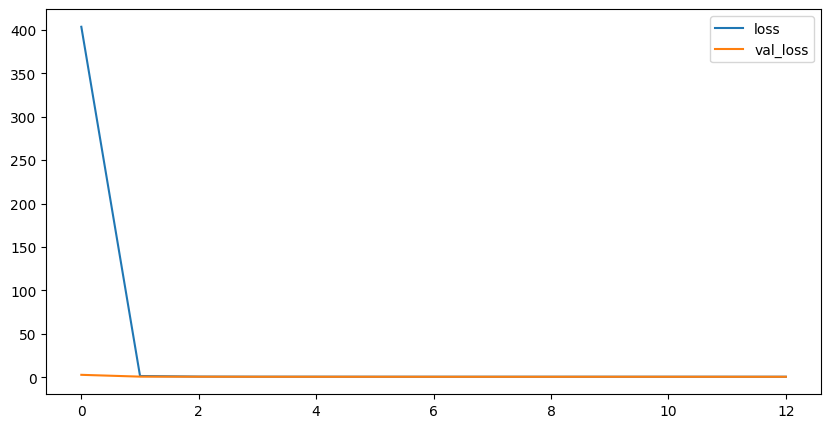

In [25]:
# Plotting train_loss vs val_loss
plt.figure(figsize=(10,5))
plt.plot(trainer.history["loss"],label="loss")
plt.plot(trainer.history["val_loss"],label="val_loss")
plt.legend()

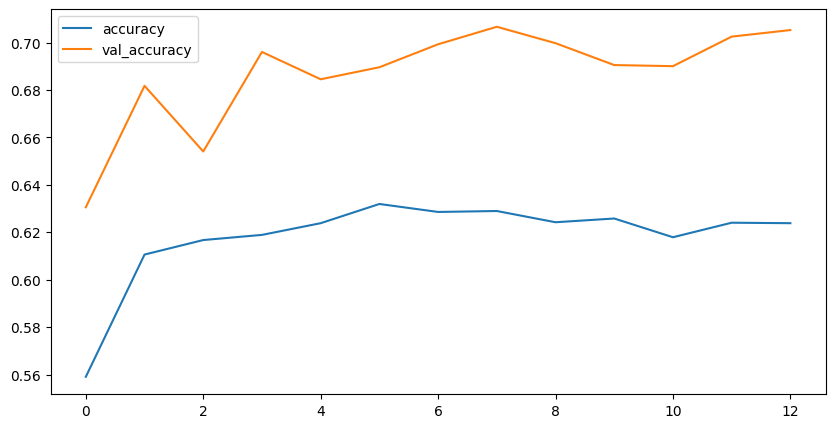

In [26]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize=(10,5))
plt.plot(trainer.history["accuracy"],label="accuracy")
plt.plot(trainer.history["val_accuracy"],label="val_accuracy")
plt.legend(loc='upper left')

In [27]:
probabilities = model.predict_generator(generator=validation_generator)

In [28]:
probabilities

array([[0.14752135],
       [0.38790217],
       [0.73412406],
       ...,
       [0.45089176],
       [0.44062227],
       [0.6225197 ]], dtype=float32)

In [29]:
y_true = validation_generator.classes

In [30]:
y_pred = probabilities > 0.5

In [31]:
y_pred

array([[False],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [ True]])

In [32]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[781 303]
 [772 312]]


<AxesSubplot: >

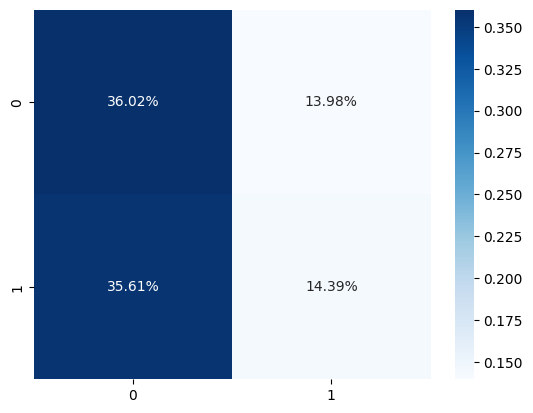

In [33]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
# means that there are 16.85% false positives and 24.72% false negatives